In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 1354536102


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 200,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
#set_pretrained_model_dropout(model, 0.05)
print("Model loaded")

Model loaded


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("The dragon flew", 50, 0.7))
test_regular_sampler()

The dragon flew into the sky and fell on top of me. I didn't have the strength to move away from the dragon, but I was still able to move to my feet, and I heard the roar of the ship.

"It's time to take my seat." I pointed at the ceiling. "You're not going to sit there, are you?"

"No, but I can't leave you. I need to get to the elevator. The elevators are on the way."

"No, I can't leave you. I need to get to the elevator."

"No, you


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

Dataset demo snapshot:
<p><msg>c "I thought Emera was going to give a press conference to warn the public."<d><scn>park2<msg>Ry "That didn't happen. She feared the potential backlash if people knew about Reza while you were still here, so - for the time being - he has been declared as a missing person."<d><scn>park2<msg>Ry "The public has been informed that if someone sees him, they are to call the police immediately. They were told he may be suffering from an affliction that makes him behave erratically."<d><sc
n>park2<msg>Ry "But some people are putting two and two together. No one has seen Reza for a while, even before he was officially declared missing."<d><scn>park2<msg>Ry "It's easy to line up the timelines and see that the murders started happening shortly after he vanished."<d><scn>park2<msg>Ry "What we know about the break-ins and thefts is also damning. The objects stolen all point toward Reza. I'm not sure how much longer they can keep this a secret."<|endoftext|><p><msg>c "

Step,Training Loss
104,2.522600
208,2.081500
312,2.008700
416,1.915100
520,1.857900
624,1.808800
728,1.759200
832,1.727500
936,1.680000
1040,1.657400


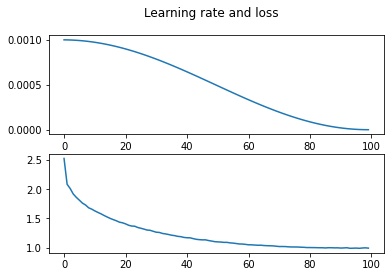

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [9]:
model.eval()
test_regular_sampler()

The dragon flew before me, its mouth set as I approached. As I drew near, I could make out the outline of a serpentine outline, but when I saw the outline, I guessed that it would be a human shape."<d><scn>black<msg>n "When I turned my head, there was no mistaking her shape."<d><scn>black<msg>n "I guessed her shape, but when I saw her, I guessed her shape."<d><scn>black<msg>n "After a moment, there was no mistaking her shape."<d><


In [13]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: black<msg>Ry "I'm fine."<d><scn>black<msg>Ry "I'm fine."<p><msg>c "I'm fine."<d><scn>black<msg>Ry "I'm fine."<d><scn>black<msg>Ry "I'm fine."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: loremapt<msg>Ad "I think I see you in the café."<d><scn>loremapt<msg>Ad "I think I see Lorem in the café."<d><scn>loremapt<msg>Ad "I think I see Lorem in the café."<d><scn>loremapt<msg>Ad "I think I see


Prompt: Oh my god, Adine. What is this?
Reply: park2<msg>Ry "I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we


Prompt: What will we do here?
Reply: black<msg>An "I sat down on a chair in Anna's lab."<d><scn>black<msg>An "I sat down on a chair in Anna's lab."<d><scn>black<msg>An "I sat d

# Sampling test

This is gonna be interesting!

In [11]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: black<msg>Ry "I'm fine."<d><scn>black<msg>Ry "I'm fine."<p><msg>c "I'm fine."<d><scn>black<msg>Ry "I'm fine."<d><scn>black<msg>Ry "I'm fine."<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: loremapt<msg>Ad "I think I see you in the café."<d><scn>loremapt<msg>Ad "I think I see Lorem in the café."<d><scn>loremapt<msg>Ad "I think I see Lorem in the café."<d><scn>loremapt<msg>Ad "I think I see

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: park2<msg>Ry "I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we were having a conversation. But then I saw Adine's face and I thought we

[Test 1] -> Prompt: What will we do here?
Reply: black<msg>An "I sat down on a chair in Anna's lab."<d><scn>black<msg>An "I sat down on a chair

In [12]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined